<h1><center>GSOC 2023</center></h1>
<h2><center>Stefan Vayl</center></h2>
<h2><center>Development of Attractors.jl</center></h2>



### Package development

Throughout work with Attractors.jl package I learned a lot of useful things about Julia and package development in general. In particular, despite I had expirience, I learned from scratch how to work with packages:
1. Setup of different working environments to properly test developed features.
2. Revise.jl which helped me to avoid recompilation of packages after each change.
3. How to use GitHub not only for commits but as a source for discussion and dynamic code review.
4. How to manage package dependencies.
5. How to write proper documentation which further will be used by users of the package.



<h2><center>Minimal Fatal Shock Algorithm</center></h2>

### Main Idea

Given arbitrary state `u0` find a miniamal perturbation such that system will be forced into another attractor from the one in which `u0` is located. 
In principal the problem converges to constraint optimization problem. Local solutions for couple of cases with explicit computation of Lagrange 
multipliers were described in paper ["Minimal Fatal Shocks in Multistable Complex Systems"](https://doi.org/10.1038/s41598-020-68805-6) by Halekotte, L., Feudel, U.

While in our case we aimed for generalization, so that the algorithm may be used for arbitrary dynamical system. 

The setup we had at the start is an API of Attractors.jl where we could obtain such called `mapper` function which can return a basin of a given state `u0`. 

### Randomised algorithm

The initial idea was to create randomised algorithm devided into two parts:
1. Random initialization.
2. Hypersphere optimization.
#### Random initialization
The idea is to generate random perturbation of the state `u0` and check if it is in the basin of another attractor. If it we find its norm and save it if the norm is smaller then previuosly obtained. We repeat the process by user specified number of steps.
#### Hypersphere optimization
Now we start with some random guess obtained during `random initialization`. The idea is that in some dimension `n` one can initialize points on the surface of the n-sphere and reduce its radius to find a better solution. The algorithms works the following way:
1. Generate random point on the surface of the n-sphere.
2. Check if it is in the basin of another attractor.
3. If it is, then reduce the radius of the n-sphere and repeat the process.
The process repeats user-specified amount of times. The decrease of the radius is also user-specified.

The algorithm turned out to be working and indeed in 2-3 dimensions we could obtain quite optimal results. But still we were seeking for improvement and more rigorous approach, as in higher dimension the algorithm behaviour was to random. 

### Black Box Problem 
The problem we faced initially was that we couldn't obtain any additional information on our constraint function as it is a black box. We can only evaluate it at some point. So we can't use any gradient based methods.
After significant research we found a way to use `BlackBoxOptim.jl` package which is designed for the problems when the constraint function is not differentiable. The idea is to use a penalty function which will be used as a constraint function. So, if we hit other basin during the search we encourage the algorithm otherwise we punish it with some penalty. 
Eventually we succeded implementing such an approach with wide range of parameters to be user tuned, such as: initial `SearchArea`, initial `guess` to optimize algorithm and give it some starting point, `MaxSteps` which allows user to perform very rigorous searches and `penalty` for very delicate setup of the algorithm.

### Final version of the algorithm
We decided to ramain both algorithms in the package as they both have their pros and cons. User has a choice to use randomised algo which is good for low dimensional systems where one can quickly obtain some satisfactory results. Or use algorithm with `BlackBoxOptim.jl` which is more rigorous and will be appropriate to use in any dimension. Also, user can specify to use both algos, so that randomised will quickly obtain some guess which is not assumed to be optimal and further this result is provided to BlackBox algorithm as a starting point to increase perfomance of the algorithm.


### Results and performance
The algorithms were tested on different dynamical systems with dimensions ranging from 2 to 10. The performance of the algorithm was surprisingly good, even in 10 dimensional famous Kuramoto system we with the rigorous setup the computation time didn't exceed 1-2 minutes. While for simplier 2-3 dimensional systems the computation time was within couple of seconds (depending on the exact systems sometimes computations were performed in less then a second). Below you can observe some `observable` (as there is not that much you can visualize in 10 dimensions) results for obtained minimal fatal shocks in Newton Fractal systems and 2D Pendulum.
 


In [2]:
using Attractors, CairoMakie

<h3><center> Newton fractal with 3 attractors</center></h3>
<p><center> Minimal Fatal shocks for 3 attractors and 4 random points (small circles)</center></p>

In [24]:
function newton_map(z, p, n)
    z1 = z[1] + im*z[2]
    dz1 = newton_f(z1, p[1])/newton_df(z1, p[1])
    z1 = z1 - dz1
    return SVector(real(z1), imag(z1))
end
newton_f(x, p) = x^p - 1
newton_df(x, p)= p*x^(p-1)




(Int32[1 1 … 2 2; 1 1 … 2 2; … ; 3 3 … 3 3; 3 3 … 3 3], Dict{Int32, StateSpaceSet{2, Float64}}(2 => 2-dimensional StateSpaceSet{Float64} with 1 points, 3 => 2-dimensional StateSpaceSet{Float64} with 1 points, 1 => 2-dimensional StateSpaceSet{Float64} with 1 points))

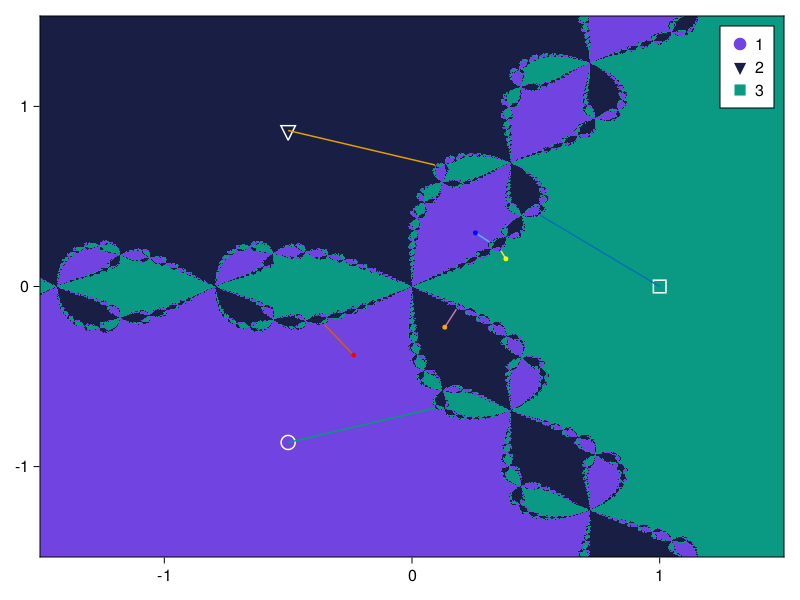

CairoMakie.Screen{IMAGE}


In [27]:
ds = DiscreteDynamicalSystem(newton_map, [0.1, 0.2], [3.0])
xg = yg = range(-1.5, 1.5; length = 800)

newton = AttractorsViaRecurrences(ds, (xg, yg);
    sparse = false, mx_chk_lost = 1000
)

basins, attractors = basins_of_attraction(newton)

newton_atr1 = [[1.0, 0.0], [-0.5, 0.8660254037844386], [-0.5, -0.8660254037844386]]
temp = heatmap_basins_attractors((xg, yg), basins, attractors) 
ax =  content(temp[1,1])
lines!(ax, [SVector{2, Float64}([1.0, 0.0]), SVector{2, Float64}([-0.48168+1, 0.395074])])
lines!(ax, [SVector{2, Float64}([-0.5, 0.866025]), (SVector{2, Float64}([-0.5, 0.866025]) +SVector{2, Float64}([0.591977, -0.191082]))])
lines!(ax, [SVector{2, Float64}([-0.5, -0.866025]), (SVector{2, Float64}([-0.5, -0.866025]) +SVector{2, Float64}([0.592005, 0.190974]))])
lines!(ax, [SVector{2, Float64}([0.132314, -0.22603]), (SVector{2, Float64}([0.132314, -0.22603]) +SVector{2, Float64}([0.0467879, 0.0994634]))])
lines!(ax, [SVector{2, Float64}([0.256257, 0.297718] ), (SVector{2, Float64}([0.256257, 0.297718] ) +SVector{2, Float64}([0.0559141, -0.0498485]))])
lines!(ax, [SVector{2, Float64}([-0.235533, -0.380948]), (SVector{2, Float64}([-0.235533, -0.380948]) +SVector{2, Float64}([-0.117335, 0.168448]))])
lines!(ax, [SVector{2, Float64}([0.37918, 0.153645] ), (SVector{2, Float64}([0.37918, 0.153645]) +SVector{2, Float64}([-0.0203836, 0.0449514]))])
scatter!(ax, [SVector{2, Float64}([0.132314, -0.22603])], markersize = 7, color = :orange)
scatter!(ax, [SVector{2, Float64}([0.256257, 0.297718])], markersize = 7, color = :blue)
scatter!(ax, [SVector{2, Float64}([-0.235533, -0.380948])], markersize = 7, color = :red)
scatter!(ax, [SVector{2, Float64}([0.37918, 0.153645])], markersize = 7, color = :yellow)
display(temp)

<h3><center> Newton fractal with 5 attractors</center></h3>

<p><center>You can observes minimal fatal shocks obtained for attractors of this system.</center></p>

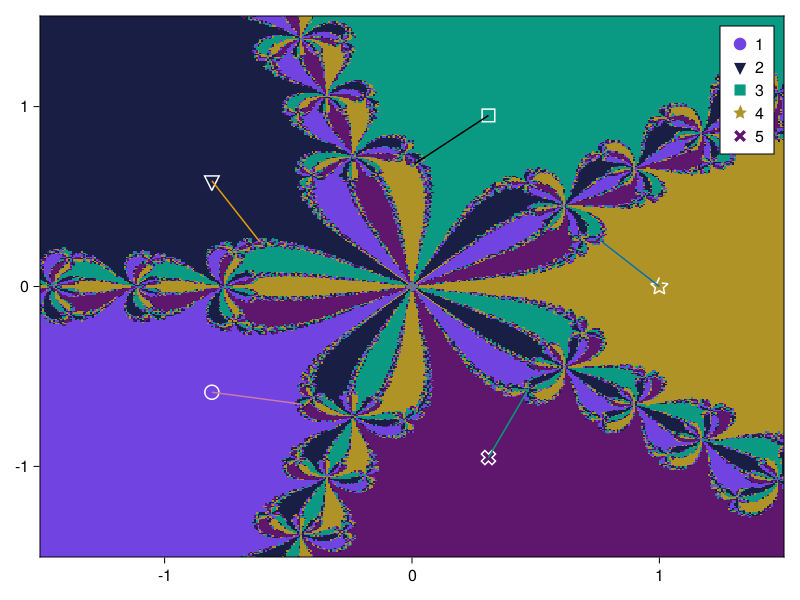

CairoMakie.Screen{IMAGE}


In [26]:


ds = DiscreteDynamicalSystem(newton_map, [0.5, 0.2], [5.0])
xg = yg = range(-1.5, 1.5; length = 400)

newton = AttractorsViaRecurrences(ds, (xg, yg);
    sparse = false, mx_chk_lost = 1000
)

basins, attractors = basins_of_attraction(newton)
temp = heatmap_basins_attractors((xg, yg), basins, attractors) 
ax =  content(temp[1,1])
lines!(ax, [SVector{2, Float64}([1.0, 0.0]), SVector{2, Float64}([-0.229924+1, 0.246176])])
lines!(ax, [SVector{2, Float64}([-0.809017, 0.587785]), (SVector{2, Float64}([-0.809017, 0.587785]) +SVector{2, Float64}([0.193582, -0.33846]))])
lines!(ax, [SVector{2, Float64}([0.309017, 0.951057]), (SVector{2, Float64}([0.309017, 0.951057]) +SVector{2, Float64}([-0.295002, -0.265871]))], color = :black)
lines!(ax, [SVector{2, Float64}([0.309017, -0.951057]), (SVector{2, Float64}([0.309017, -0.951057]) +SVector{2, Float64}([0.163513, 0.384485]))])
lines!(ax, [SVector{2, Float64}([-0.809017, -0.587785] ), (SVector{2, Float64}([-0.809017, -0.587785] ) +SVector{2, Float64}([0.360264, -0.065999]))])
display(temp)

<h3><center> 2d Basins of the 4D magnetic pendulum</center></h3>

<p><center>You can observes minimal fatal shocks obtained for attractors of this system.</center></p>

In [9]:
using PredefinedDynamicalSystems
ds = PredefinedDynamicalSystems.magnetic_pendulum(d=0.2, α=0.2, ω=0.8, N=3)

psys = ProjectedDynamicalSystem(ds, [1, 2], [0.0, 0.0])

attractors = Dict(i => StateSpaceSet([dynamic_rule(ds).magnets[i]]) for i in 1:3)

mapper = AttractorsViaProximity(psys, attractors)
mapper.ds
xg = yg = range(-4, 4; length = 201)
grid = (xg, yg)
basins, attractors = basins_of_attraction(mapper, grid; show_progress = false)

┌ Info: Minimum distance between attractors computed: 1.7320508075688772
└ @ Attractors /Users/stefanvayl/.julia/packages/Attractors/OE0O8/src/mapping/attractor_mapping_proximity.jl:87


(Int32[3 1 … 2 3; 1 1 … 2 2; … ; 3 3 … 3 3; 1 2 … 1 2], Dict{Int64, StateSpaceSet{2, Float64}}(2 => 2-dimensional StateSpaceSet{Float64} with 1 points, 3 => 2-dimensional StateSpaceSet{Float64} with 1 points, 1 => 2-dimensional StateSpaceSet{Float64} with 1 points))

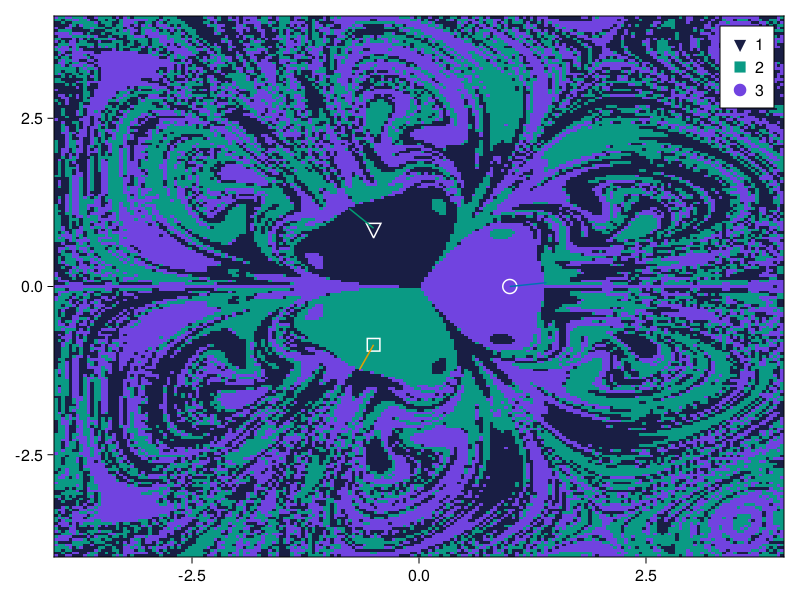

CairoMakie.Screen{IMAGE}


In [13]:
temp = heatmap_basins_attractors((xg, yg), basins, attractors) 

ax =  content(temp[1,1])

lines!(ax, [SVector{2, Float64}([1.0, -2.44929e-16]), (SVector{2, Float64}([1.0, -2.44929e-16]) +SVector{2, Float64}([0.404128, 0.0570765]))])
lines!(ax, [SVector{2, Float64}([-0.5, -0.866025]), (SVector{2, Float64}([-0.5, -0.866025]) +SVector{2, Float64}([-0.155824, -0.37165]))])
lines!(ax, [SVector{2, Float64}([-0.5, 0.866025]), (SVector{2, Float64}([-0.5, 0.866025]) +SVector{2, Float64}([-0.269378, 0.293316]))])


display(temp)
